In [1]:
import os
import numpy as np
import time
import copy
import sys
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import molog_loading_utils as mlu

In [2]:
#folder = "/home/kristjan/sshfs/daint_scratch/cp2k_cnt_orbitals/"
#
#file_basis_set = folder + "BR"
#
#
#file_xyz = folder + "c2h2_rot/p.xyz"
#
#file_molog = folder + "c2h2_rot/morb_not_all/PROJ-COEFF-1_0.MOLog"
#
#file_cp2k_inp = folder + "c2h2_rot/morb_not_all/cp2k.inp"


#folder = "/home/kristjan/local_work/12mol_7agnr/"
#
#file_basis_set = folder + "BR"
#
#
#file_xyz = folder + "12mol_7agnr_opt.xyz"
#
#file_molog = folder + "morbs/PROJ-COEFF-1_0.MOLog"
#
#file_cp2k_inp = folder + "morbs/cp2k.inp"


folder = "/home/kristjan/local_work/finite_ideal_cnt_morbs/"

file_basis_set = folder + "BR"


file_xyz = folder + "finite_ideal_cnt.xyz"

file_molog = folder + "PROJ-COEFF-1_0.MOLog"

file_cp2k_inp = folder + "cp2k.inp"

In [3]:
time1 = time.time()
elem_basis_names, cell, cell_n = mlu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time2 = time.time()
at_positions, at_elems = mlu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time2))

time3 = time.time()
basis_sets = mlu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time3))

time4 = time.time()
morb_composition, morb_energies = mlu.read_and_process_molog(file_molog)
print("Read molog: %.3f" % (time.time()-time4))

Read cp2k input: 0.014
Read xyz: 0.074
Read basis sets: 0.005
Reading CP2K MOs from:/home/kristjan/local_work/finite_ideal_cnt_morbs/PROJ-COEFF-1_0.MOLog
Metallic system
Found 2001 MOs spanned by 33492 basis functions centered on 2400 atoms.
Read molog: 246.332


In [4]:
def spherical_harmonic_grid(l, m, x_grid, y_grid, z_grid):
    c = (2.0/np.pi)**(3.0/4.0)
    
    # s orbitals
    if (l, m) == (0, 0):
        return c
    
    # p orbitals
    elif (l, m) == (1, -1):
        return c*2.0*y_grid
    elif (l, m) == (1, 0):
        return c*2.0*z_grid
    elif (l, m) == (1, 1):
        return c*2.0*x_grid
    
    # d orbitals
    elif (l, m) == (2, -2):
        return c*4.0*x_grid*y_grid
    elif (l, m) == (2, -1):
        return c*4.0*y_grid*z_grid
    elif (l, m) == (2, 0):
        return c*2.0/np.sqrt(3)*(2*z_grid**2-x_grid**2-y_grid**2)
    elif (l, m) == (2, 1):
        return c*4.0*z_grid*x_grid
    elif (l, m) == (2, 2):
        return c*2.0*(x_grid**2-y_grid**2)
    
    print("No spherical harmonic found for l=%d, m=%d" % (l, m))
    return 0


def add_local_to_global_grid_slow(loc_grid, glob_grid, origin_diff):
    loc_nx, loc_ny = np.shape(loc_grid)
    glob_nx, glob_ny = np.shape(glob_grid)
    od = origin_diff
    
    if loc_nx <= glob_nx and loc_ny <= glob_ny:
        ix_arr = (np.arange(loc_nx) + od[0]) % glob_nx
        iy_arr = (np.arange(loc_ny) + od[1]) % glob_ny
        ix_grid, iy_grid = np.meshgrid(ix_arr, iy_arr, indexing='ij')
        glob_grid[ix_grid, iy_grid] += loc_grid
    else:
        n_x_arr = np.ceil(loc_nx/glob_nx)
        n_y_arr = np.ceil(loc_ny/glob_ny)
        
        ix_is = np.array_split(np.arange(loc_nx), n_x_arr)
        iy_is = np.array_split(np.arange(loc_ny), n_y_arr)
        
        for ix_i in ix_is:
            for iy_i in iy_is:
                ix_i_grid, iy_i_grid = np.meshgrid(ix_i, iy_i, indexing='ij')
                ix_a_grid = (ix_i_grid + od[0]) % glob_nx
                iy_a_grid = (iy_i_grid + od[1]) % glob_ny
                glob_grid[ix_a_grid, iy_a_grid] += loc_grid[ix_i_grid, iy_i_grid]
                
def add_local_to_global_grid(loc_grid, glob_grid, origin_diff):
    loc_nx, loc_ny = np.shape(loc_grid)
    glob_nx, glob_ny = np.shape(glob_grid)
    od = origin_diff
    
    # Move the origin_diff vector to the main global cell (not an image)
    od = od % glob_nx
        
    ixs = [[od[0], od[0] + loc_nx]]
    l_ixs = [0]
    while ixs[-1][1] > glob_nx:
        overshoot = ixs[-1][1]-glob_nx
        ixs[-1][1] = glob_nx
        l_ixs.append(l_ixs[-1]+glob_nx-ixs[-1][0])
        ixs.append([0, overshoot])
    l_ixs.append(loc_nx)
        
    iys = [[od[1], od[1] + loc_ny]]
    l_iys = [0]
    while iys[-1][1] > glob_ny:
        overshoot = iys[-1][1]-glob_ny
        iys[-1][1] = glob_ny
        l_iys.append(l_iys[-1]+glob_ny-iys[-1][0])
        iys.append([0, overshoot])
    l_iys.append(loc_ny)
        
    for i, ix in enumerate(ixs):
        for j, iy in enumerate(iys):
            glob_grid[ix[0]:ix[1], iy[0]:iy[1]] += loc_grid[l_ixs[i]:l_ixs[i+1], l_iys[j]:l_iys[j+1]]
        
        
#loc_grid = np.ones((17, 17))
#glob_grid = np.zeros((8, 8))
#origin_diff = np.array([2, 2])
#
#add_local_to_global_grid(loc_grid, glob_grid, origin_diff)
#glob_grid             

In [5]:
height = 1.0 # Plane distance in z direction from topmost atom; angstroms

emax =  2.0 # eV
emin = -2.0 # eV

In [6]:
# Sort out molecular orbitals in the specified energy range
sel_morb_composition = []
sel_morb_energies = []
for i_mo, morb in enumerate(morb_composition):
    energy = morb_energies[i_mo]
    if energy > emin and energy < emax:
        sel_morb_energies.append(energy)
        sel_morb_composition.append(morb)
        
print("Selected mol. orbitals %d/%d" % (len(sel_morb_composition), len(morb_composition)))

Selected mol. orbitals 593/2001


In [7]:
# Define the plane

time1 = time.time()

carb_positions = at_positions[np.array(at_elems)[:, 0] == 'C']

plane_z = np.max(carb_positions[:, 2]) + height*ang_2_bohr

# Use similar grid spacing to cp2k cube files
dv = cell[0:2]/cell_n[0:2]
x_arr = np.arange(0, cell[0], dv[0])
y_arr = np.arange(0, cell[1], dv[1])
x_grid, y_grid = np.meshgrid(x_arr, y_arr, indexing='ij')

# Define small grid for orbital evaluation
# and convenient PBC implementation
loc_cell = np.array([10.0,  10.0])*ang_2_bohr
x_arr_loc = np.arange(0, loc_cell[0], dv[0])
y_arr_loc = np.arange(0, loc_cell[1], dv[1])
loc_cell_n = np.array([len(x_arr_loc), len(y_arr_loc)])
# Define it such that the origin is somewhere
# in the middle but exactly on a grid point
mid_ixs = (loc_cell_n/2).astype(int)
x_arr_loc -= x_arr_loc[mid_ixs[0]]
y_arr_loc -= y_arr_loc[mid_ixs[1]]
x_grid_loc, y_grid_loc = np.meshgrid(x_arr_loc, y_arr_loc, indexing='ij')

# Some info
print("Main cell:   ", cell, cell_n)
print("Local plane: ", loc_cell, loc_cell_n)


morb_planes = [np.zeros(cell_n[0:2]) for _ in range(len(sel_morb_composition))]

print("---- Setup: %.4f" % (time.time() - time1))

time_radial_calc = 0.0
time_spherical = 0.0
time_loc_glob_add = 0.0


for i_at in range(len(at_positions)):
        elem = at_elems[i_at][0]
        pos = at_positions[i_at]
        
        # how does the position match with the grid?
        int_shift = (pos[0:2]/dv).astype(int)
        frac_shift = pos[0:2]/dv - int_shift
        
        # Shift the local grid such that origin is on the atom
        x_grid_rel_loc = x_grid_loc - frac_shift[0]*dv[0]
        y_grid_rel_loc = y_grid_loc - frac_shift[1]*dv[1]
        
        z_rel = plane_z - pos[2]
        
        r_vec_2 = x_grid_rel_loc**2 + y_grid_rel_loc**2 + z_rel**2
        
        for i_shell, shell in enumerate(basis_sets[elem]):
            l = shell[0]
            es = shell[1]
            cs = shell[2]
            
            # Calculate the radial part of the atomic orbital
            time2 = time.time()
            radial_part = np.zeros(loc_cell_n)
            for e, c in zip(es, cs):
                radial_part += c*np.exp(-1.0*e*r_vec_2)
            time_radial_calc += time.time() - time2
            
            for i, m in enumerate(range(-l, l+1, 1)):
                time2 = time.time()
                atomic_orb = radial_part*spherical_harmonic_grid(l, m,
                                                                 x_grid_rel_loc,
                                                                 y_grid_rel_loc,
                                                                 z_rel)
                time_spherical += time.time() - time2
                
                for i_mo in range(len(sel_morb_composition)):
                    coef = sel_morb_composition[i_mo][i_at][i_shell][i]

                    # Add the atomic orbital on the local grid to the global grid
                    origin_diff = int_shift - mid_ixs
                    time2 = time.time()
                    add_local_to_global_grid(coef*atomic_orb, morb_planes[i_mo], origin_diff)
                    time_loc_glob_add += time.time() - time2
            

print("---- Radial calc time : %4f" % time_radial_calc)
print("---- Spherical calc time : %4f" % time_spherical)
print("---- Loc -> glob time : %4f" % time_loc_glob_add)
print("---- Total time: %.4f"%(time.time() - time1))                 

Main cell:    [ 835.25894745   47.24315314   47.24315314] [5525  313  313]
Local plane:  [ 18.89726125  18.89726125] [126 126]
---- Setup: 0.0742
---- Radial calc time : 18.538139
---- Spherical calc time : 1.152701
---- Loc -> glob time : 1360.737064
---- Total time: 1428.2079


In [8]:
i_homo = 0
i_lumo = 0

for i, en in enumerate(sel_morb_energies):
    if en > 0.0:
        i_lumo = i
        i_homo = i - 1
        break
print(i_homo, i_lumo)

344 345


In [55]:
def read_cp2k_cube_file(filename):

    f = open(filename, 'r')

    title = f.readline()
    comment = f.readline()

    line = f.readline().split()
    natoms = int(line[0])
    b2A = 0.529177
    origin = np.array(line[1:], dtype=float) * b2A

    shape = np.empty(3, dtype=int)
    cell = np.empty((3, 3))
    
    for i in range(3):
        line = f.readline().split()
        n = int(line[0])
        xyz = np.array(line[1:], dtype=float) * b2A
        shape[i] = n
        cell[i] = n * xyz
        

    numbers = np.empty(natoms, int)
    positions = np.empty((natoms, 3))
    for i in range(natoms):
        line = f.readline().split()
        numbers[i] = int(line[0])
        positions[i] = [float(s) for s in line[2:]]
    positions *= b2A 
    
    data = np.array(f.read().split(), dtype=float)
    data = data.reshape(shape)

    f.close()
    
    return cell, data

In [56]:
c_cell = None
c_data = None
c_cell, c_data = read_cp2k_cube_file("/home/kristjan/local_work/12mol_7agnr/morbs/PROJ-WFN_00720_1-1_0.cube")

c_cell_n = np.shape(c_data)

c_dv = c_cell/c_cell_n

c_index = int((plane_z/ang_2_bohr)/c_dv[2, 2])

plane = c_data[:, :, c_index]

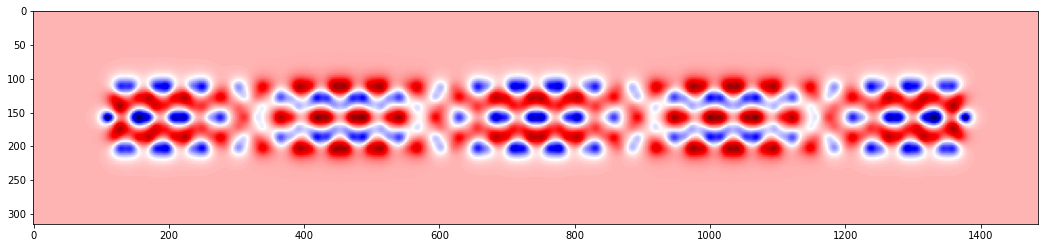

In [57]:
plt.figure(figsize=(18, 8))
plt.imshow(plane.T, cmap='seismic')
#plt.colorbar()
plt.show()

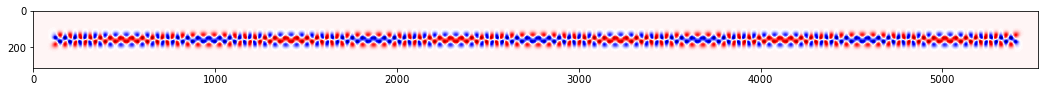

In [9]:
plt.figure(figsize=(18, 8))
plt.imshow(morb_planes[i_homo-4].T, cmap='seismic')
#plt.colorbar()
plt.show()

340


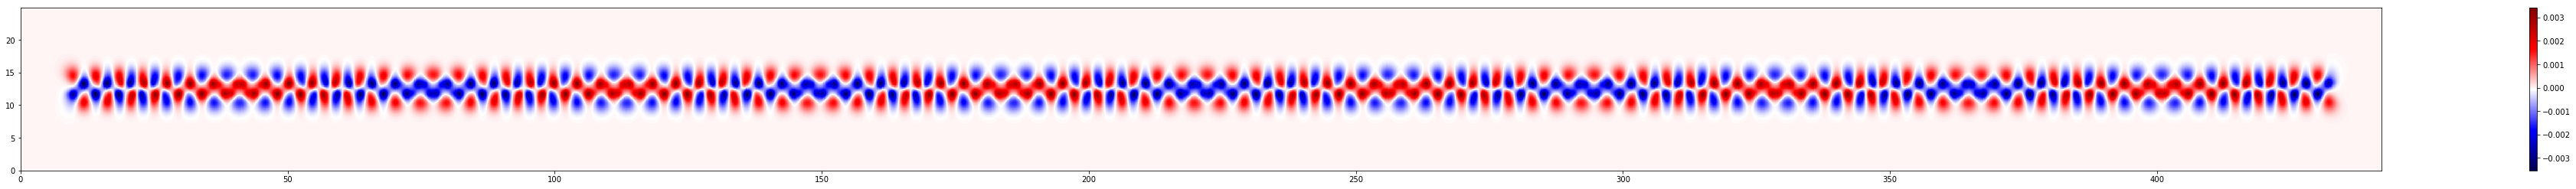

341


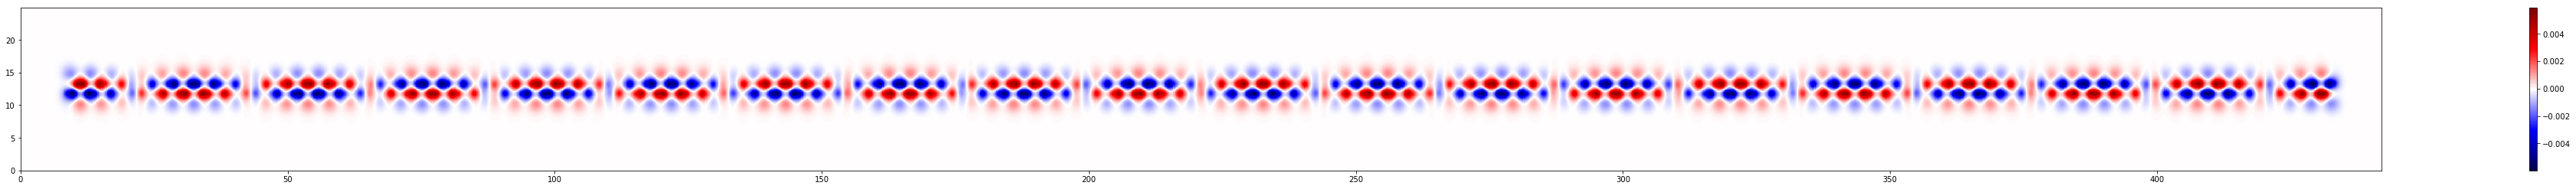

342


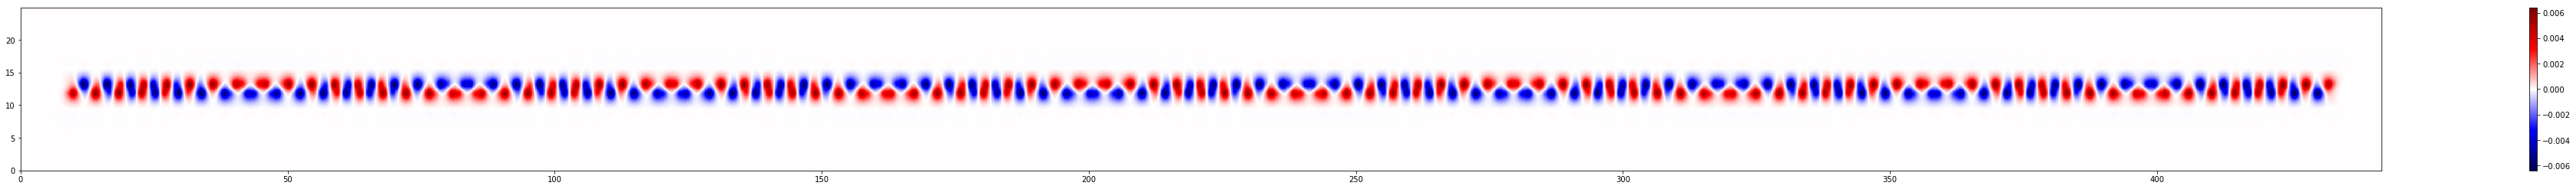

343


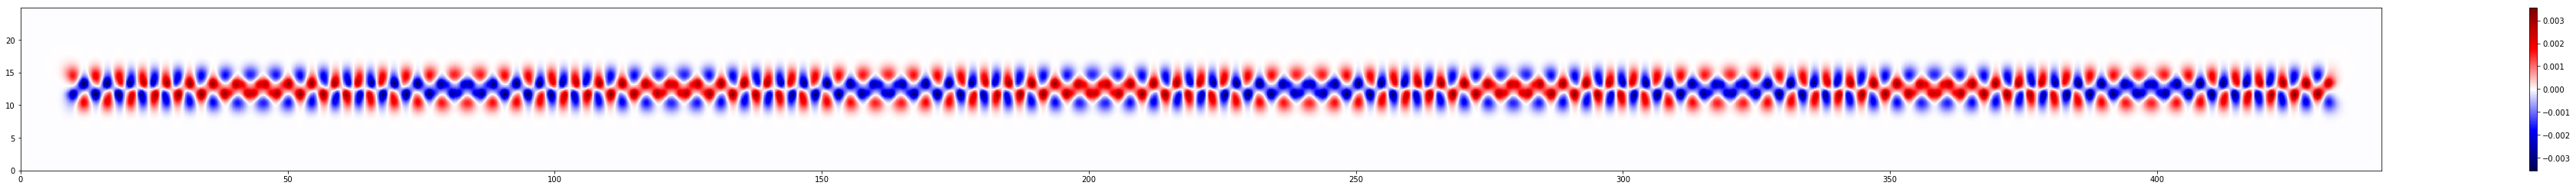

344


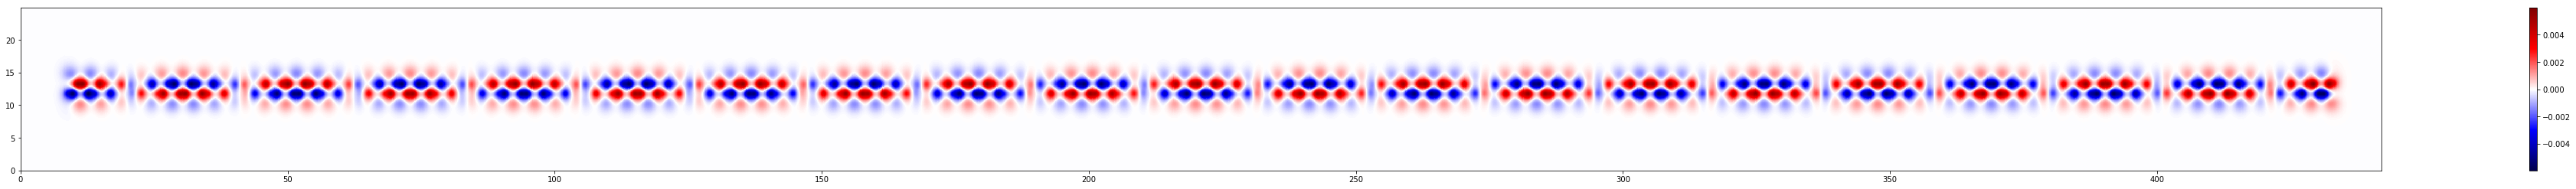

345


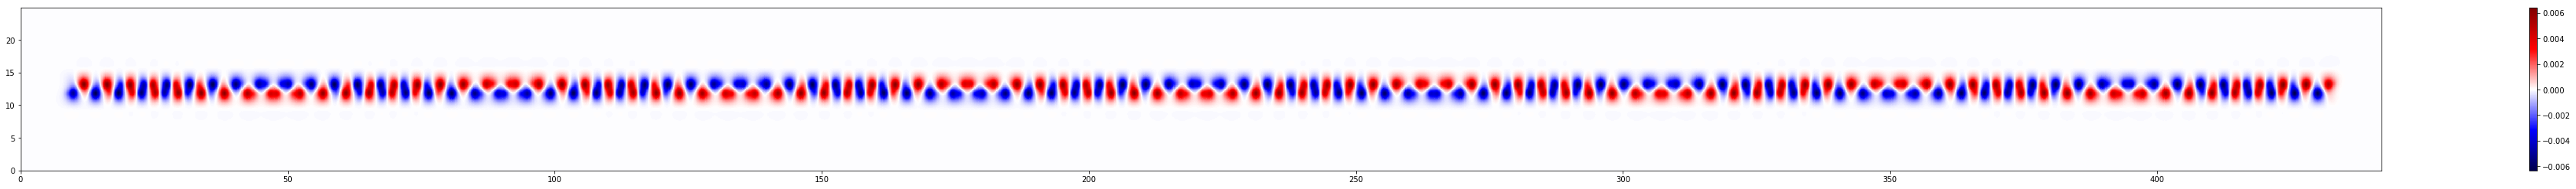

346


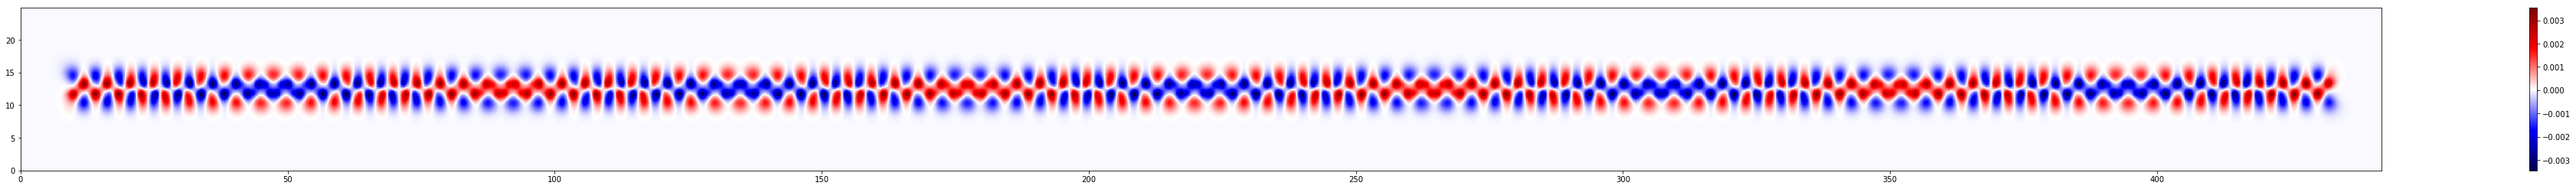

347


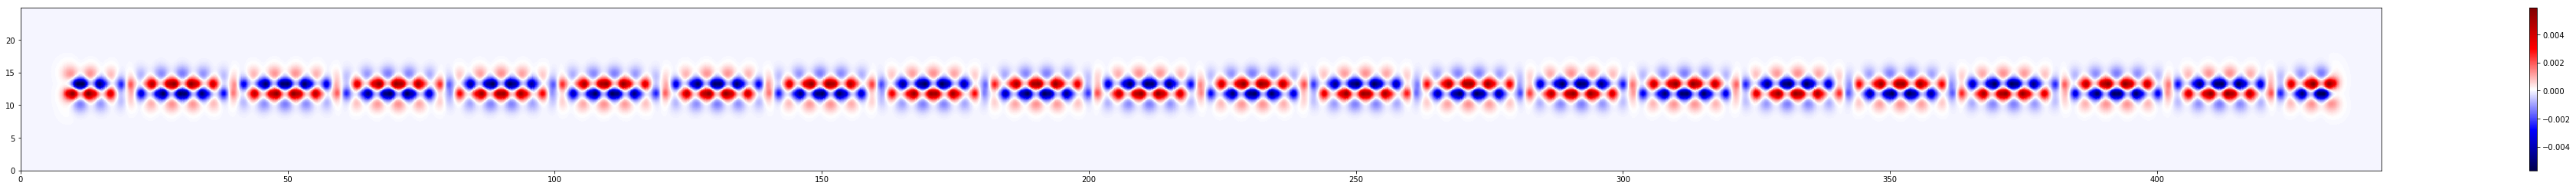

In [10]:
for i in range(i_homo-4, i_homo+4):
    print(i)
    pltsize = 0.0125
    plt.figure(figsize=(cell_n[0]*pltsize, cell_n[1]*pltsize))

    plt.pcolormesh(x_grid/ang_2_bohr, y_grid/ang_2_bohr, morb_planes[i], cmap='seismic')
    plt.colorbar()
    plt.show()

In [60]:
print(sel_morb_energies[i_homo+3])
print(sel_morb_energies[i_homo+2])
print(sel_morb_energies[i_homo+1])
print(sel_morb_energies[i_homo])
print(sel_morb_energies[i_homo-1])
print(sel_morb_energies[i_homo-2])

0.0211399213163
0.0169352996183
0.0168518245015
-0.014332021504
-0.0208156758743
-0.0208988861056


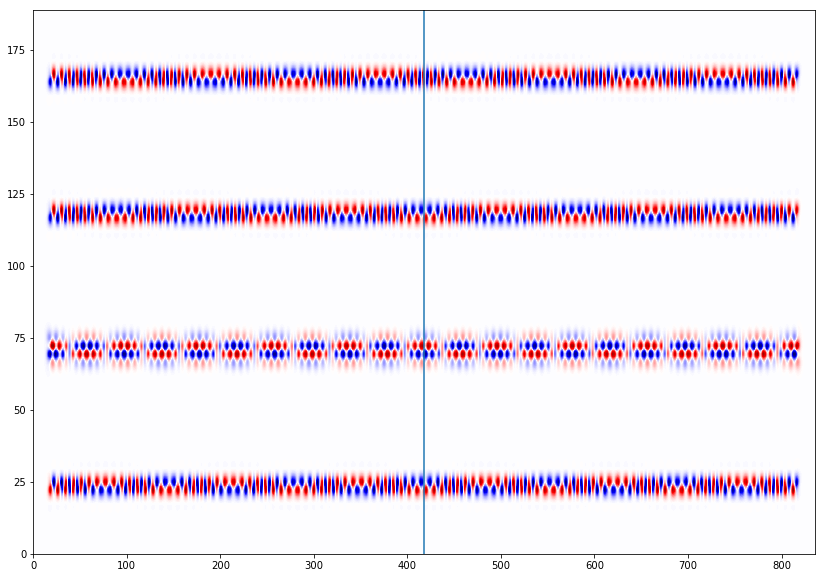

In [61]:
select = [i_homo - 5, i_homo, i_lumo, i_lumo + 3]

sel_morbs = np.zeros((cell_n[0], 4*cell_n[1]))

for i, i_mo in enumerate(select):
    sel_morbs[:, i*cell_n[1]:(i+1)*cell_n[1]] = morb_planes[i_mo]
    
y_arr_inc = np.arange(0, 4*cell[1], dv[1])

x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')
    
plt.figure(figsize=(14, 10))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, cmap='seismic') # seismic bwr
plt.axvline(np.max(x_grid_inc)/2)
plt.show()

In [42]:
de = 0.01

# broadening
fwhm = 0.15

def lorentzian(x):
    gamma = 0.5*fwhm
    return gamma/(np.pi*(x**2+gamma**2))
                     
def gaussian(x):
    sigma = fwhm/2.3548
    return np.exp(-x**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))


e_arr = np.arange(emin, emax, de)

x_arr_ang = x_arr / ang_2_bohr

x_e_grid, e_grid = np.meshgrid(x_arr_ang, e_arr, indexing='ij')

pldos = np.zeros((cell_n[0], len(e_arr)))

for i_mo, morb_plane in enumerate(morb_planes):
    en = sel_morb_energies[i_mo]
    avg_morb = np.mean(morb_plane**2, axis=1)
    
    morb_ldos_broad = np.outer(avg_morb, lorentzian(e_arr - en))
    
    pldos += morb_ldos_broad

    
ncrop_l = 105
ncrop_r = 115

pldos_cropped = pldos[ncrop_l:-ncrop_r]
x_e_grid_cropped = x_e_grid[ncrop_l:-ncrop_r]
e_grid_cropped = e_grid[ncrop_l:-ncrop_r]

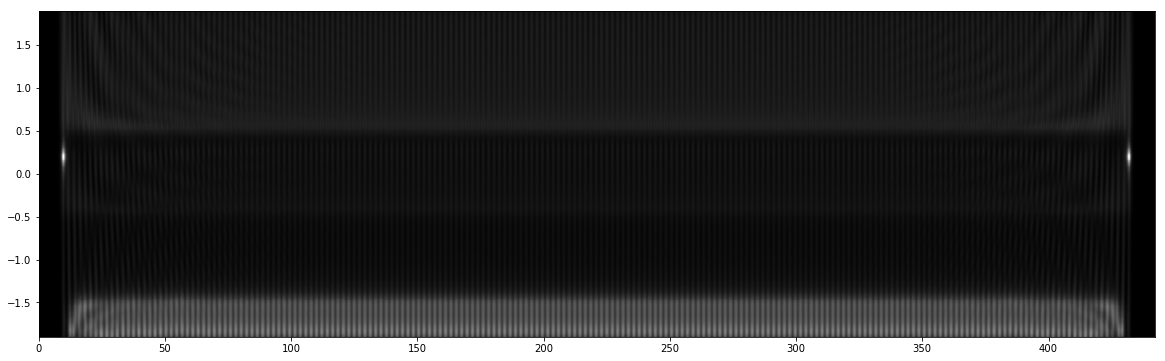

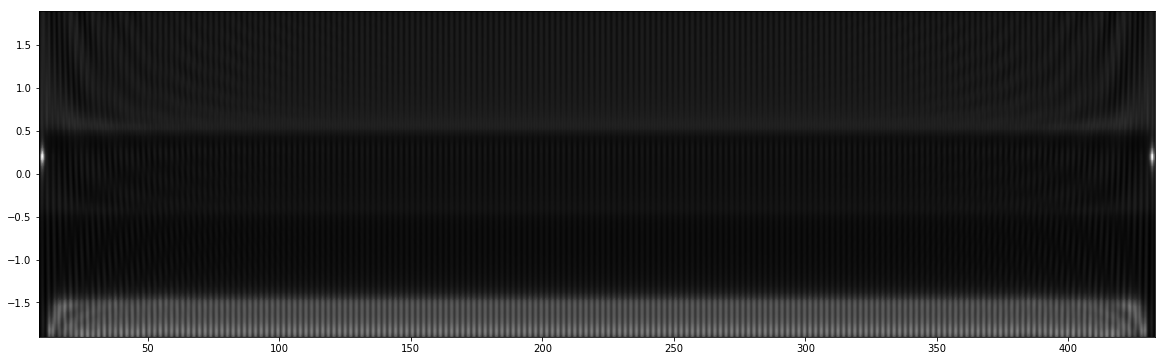

In [43]:
elim = (-1.9, 1.9)

e_i = (np.array((elim[0]-np.min(e_grid), elim[1]-np.max(e_grid)))/de).astype(int)

plt.figure(figsize=(20, 6))
plt.pcolormesh(x_e_grid[:, e_i[0]:e_i[1]],
               e_grid[:, e_i[0]:e_i[1]],
               pldos[:, e_i[0]:e_i[1]], cmap='gray')
plt.show()

plt.figure(figsize=(20, 6))
plt.pcolormesh(x_e_grid_cropped[:, e_i[0]:e_i[1]],
               e_grid_cropped[:, e_i[0]:e_i[1]],
               pldos_cropped[:, e_i[0]:e_i[1]], cmap='gray')
plt.show()

In [44]:
# in k-space

ft = np.fft.rfft(pldos_cropped, axis=0)
aft = np.abs(ft)

dx = x_arr_ang[1] - x_arr_ang[0] # angstroms !!!

# Corresponding k points
k_arr = 2*np.pi*np.fft.rfftfreq(len(pldos_cropped[:, 0]), dx)
# Note: Since we took the FT of the charge density, the wave vectors are
#       twice the ones of the underlying wave function.
k_arr = k_arr / 2

n_k = len(aft[:, 0])

# Following has slight incorrect shift
#kmin = 0.0
#kmax = np.pi / dx
#kmax = kmax / 2
#k_arr = np.linspace(kmin, kmax, n_k)

k_grid, e_k_grid = np.meshgrid(k_arr, e_arr, indexing='ij')

# Lattice spacing for the ribbon = 3x c-c distance
# Brillouin zone boundary [1/angstroms]
bzboundary = np.pi / (3 * 1.43)

dk = k_arr[1]
bzb_i = int((bzboundary)/dk)+2

# Shift by 0.5*dk so that the k value is in middle of the corresponding cell
k_grid -= 0.5*dk

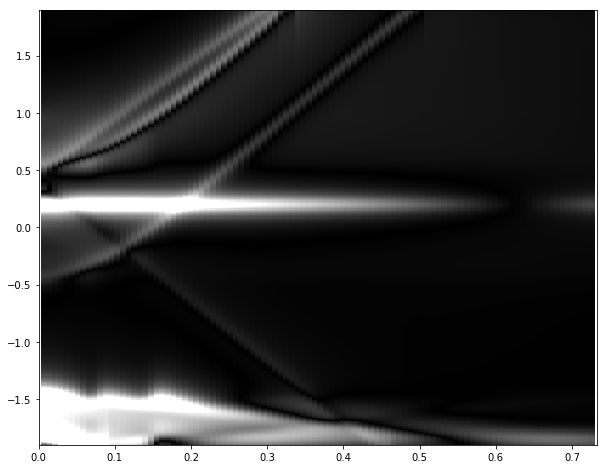

In [45]:
plt.figure(figsize=(10, 8))

max_val = np.max(aft[:bzb_i, e_i[0]:e_i[1]])

plt.pcolormesh(k_grid[:bzb_i, e_i[0]:e_i[1]],
               e_k_grid[:bzb_i, e_i[0]:e_i[1]],
               aft[:bzb_i, e_i[0]:e_i[1]],
               vmax=0.01*max_val, cmap='gray')
plt.xlim([0.0, bzboundary])
plt.show()

## Only one orbital

In [107]:
de = 0.01

# broadening
fwhm = 0.15

def lorentzian(x):
    gamma = 0.5*fwhm
    return gamma/(np.pi*(x**2+gamma**2))
                     
def gaussian(x):
    sigma = fwhm/2.3548
    return np.exp(-x**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))


e_arr = np.arange(emin, emax, de)

x_arr_ang = np.linspace(0.0, cell[0]/ang_2_bohr, np.shape(plane)[0]) 

x_e_grid, e_grid = np.meshgrid(x_arr_ang, e_arr, indexing='ij')

pldos = np.zeros((np.shape(plane)[0], len(e_arr)))

i_mo = i_homo-4
morb_plane = plane

en = sel_morb_energies[i_mo]
avg_morb = np.mean(morb_plane**2, axis=1)

morb_ldos_broad = np.outer(avg_morb, lorentzian(e_arr - en))

pldos += morb_ldos_broad

In [ ]:
e_arr = np.arange(emin, emax, de)

x_arr_ang = x_arr / ang_2_bohr

x_e_grid, e_grid = np.meshgrid(x_arr_ang, e_arr, indexing='ij')

pldos = np.zeros((cell_n[0], len(e_arr)))

i_mo = i_homo-4
morb_plane = morb_planes[i_mo]

en = sel_morb_energies[i_mo]
avg_morb = np.mean(morb_plane**2, axis=1)

morb_ldos_broad = np.outer(avg_morb, lorentzian(e_arr - en))

pldos += morb_ldos_broad


ncrop = 70

pldos_cropped = pldos[ncrop:-ncrop]
x_e_grid_cropped = x_e_grid[ncrop:-ncrop]
e_grid_cropped = e_grid[ncrop:-ncrop]

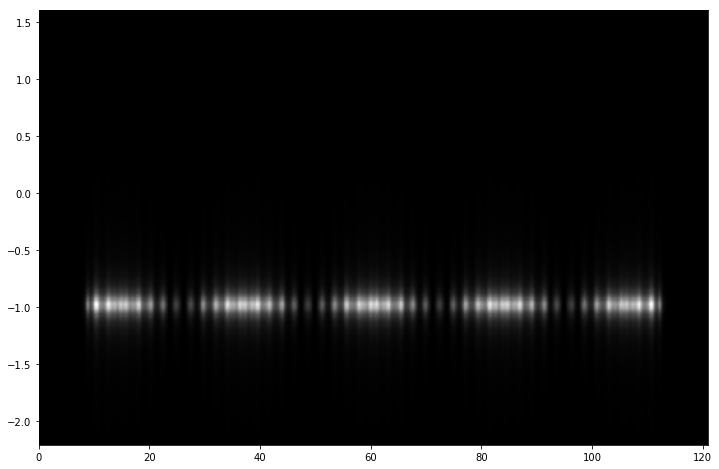

In [108]:
elim = (-2.2, 1.6)

e_i = (np.array((elim[0]-np.min(e_grid), elim[1]-np.max(e_grid)))/de).astype(int)

plt.figure(figsize=(12, 8))
plt.pcolormesh(x_e_grid[:, e_i[0]:e_i[1]],
               e_grid[:, e_i[0]:e_i[1]],
               pldos[:, e_i[0]:e_i[1]], cmap='gray')
plt.show()

In [109]:
# in k-space

ft = np.fft.rfft(pldos_cropped, axis=0)
aft = np.abs(ft)

dx = x_arr_ang[1] - x_arr_ang[0] # angstroms !!!

# Corresponding k points
k_arr = 2*np.pi*np.fft.rfftfreq(len(pldos[:, 0]), dx)
# Note: Since we took the FT of the charge density, the wave vectors are
#       twice the ones of the underlying wave function.
k_arr = k_arr / 2

n_k = len(aft[:, 0])

# Following has slight incorrect shift
#kmin = 0.0
#kmax = np.pi / dx
#kmax = kmax / 2
#k_arr = np.linspace(kmin, kmax, n_k)

k_grid, e_k_grid = np.meshgrid(k_arr, e_arr, indexing='ij')

# Lattice spacing for the ribbon = 3x c-c distance
# Brillouin zone boundary [1/angstroms]
bzboundary = np.pi / (3 * 1.43)

dk = k_arr[1]
bzb_i = int((bzboundary)/dk)+2

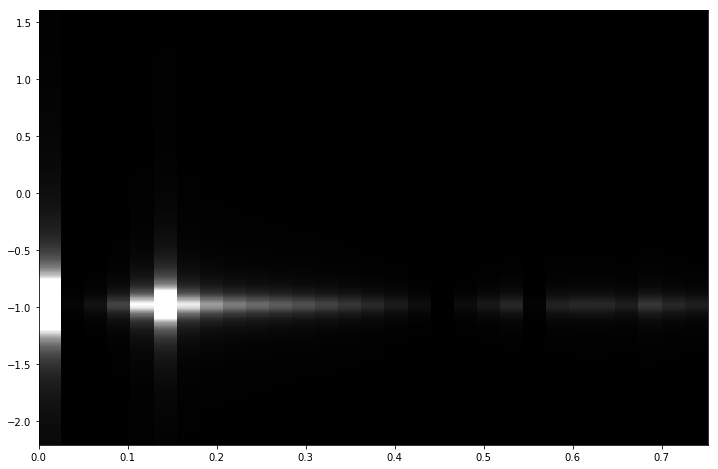

In [110]:
plt.figure(figsize=(12, 8))

max_val = np.max(aft[:bzb_i, e_i[0]:e_i[1]])

plt.pcolormesh(k_grid[:bzb_i, e_i[0]:e_i[1]],
               e_k_grid[:bzb_i, e_i[0]:e_i[1]],
               aft[:bzb_i, e_i[0]:e_i[1]],
               vmax=0.1*max_val, cmap='gray')
plt.show()